In [ ]:
!pip install nltk
!python -m spacy download en_core_web_sm -q

2023-11-17 17:41:14.002659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 17:41:14.002740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 17:41:14.002790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 17:41:14.032161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 17:41:17.495683: W tensorflow/compiler/

In [ ]:
import pandas as pd

# Download spacy for the english language
import en_core_web_sm
nlp = en_core_web_sm.load()
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from gensim import models, corpora
from wordcloud import WordCloud
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding='ISO-8859-1"')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.rename(columns={'v1': 'target', 'v2': 'text', 'Unnamed: 2': 'text_1', 'Unnamed: 3': 'text_2', 'Unnamed: 4': 'text_3'})
df.head()

,target,text,text_1,text_2,text_3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Calculate the value counts
value_counts = df['target'].value_counts()

# Calculate the value counts
fig = px.pie(values=value_counts.values,
             names=value_counts.index,
             title='Spam & Ham repartition')

fig.update_traces(textinfo='percent+label', textposition='inside', texttemplate='%{label}<br>(%{percent})')
fig.update_layout(showlegend=False)
fig.update_layout(title={'text': 'Pie Chart with Customized Text', 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  showlegend=False,
                  title_font=dict(size=20))
fig.show()
print("The repartion between Spam and Ham is imbalanced")

The repartion between Spam and Ham is imbalanced


In [ ]:
df_col01=df.loc[:,['target','text']]

In [ ]:
# Create a list for the 4 dataframes (the 2 previous dataframes preprocessed with or without removal of special characters)
df_preprocessed_dict = {}


df_preprocessed_dict["preprocessing_without_special_cha"] = df_col01.copy()
df_preprocessed_dict["preprocessing_without_special_cha"]["cleaned_text"] = df_preprocessed_dict["preprocessing_without_special_cha"]["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df_preprocessed_dict["preprocessing_without_special_cha"]["cleaned_text"] = df_preprocessed_dict["preprocessing_without_special_cha"]["cleaned_text"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_preprocessed_dict["preprocessing_without_special_cha"]["cleaned_text"] = df_preprocessed_dict["preprocessing_without_special_cha"]["cleaned_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df_preprocessed_dict["preprocessing_without_special_cha"]["target"] = df_preprocessed_dict["preprocessing_without_special_cha"]["target"].apply(lambda x: 0 if x == "ham" else 1)



df_preprocessed_dict["preprocessing_with_special_cha"] = df_col01.copy()
df_preprocessed_dict["preprocessing_with_special_cha"]["cleaned_text"] = df_preprocessed_dict["preprocessing_with_special_cha"]["text"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_preprocessed_dict["preprocessing_with_special_cha"]["cleaned_text"] = df_preprocessed_dict["preprocessing_with_special_cha"]["cleaned_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df_preprocessed_dict["preprocessing_with_special_cha"]["target"] = df_preprocessed_dict["preprocessing_with_special_cha"]["target"].apply(lambda x: 0 if x == "ham" else 1)


In [ ]:
tokenizer_dict={}

for df_name, df in df_preprocessed_dict.items():
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="out_of_vocab")
  tokenizer.fit_on_texts(df["cleaned_text"])
  df["encoded_text"] = tokenizer.texts_to_sequences(df["cleaned_text"])
  tokenizer_dict[df_name] = tokenizer

In [ ]:
vocabulary_data = {}
for df_name, df in df_preprocessed_dict.items():
    vocab_size = len(tokenizer_dict[df_name].word_index)
    vocabulary_data[df_name] = {'Vocabulary Size': vocab_size}
vocabulary_df = pd.DataFrame.from_dict(vocabulary_data, orient='index')
print(vocabulary_df)
print("\n")
print("Wihtout the special character, the vocabulary increase considering that website or e-mail contains special characters")

                                   Vocabulary Size
preprocessing_with_special_cha                7603
preprocessing_without_special_cha             8189


Wihtout the special character, the vocabulary increase considering that website or e-mail contains special characters


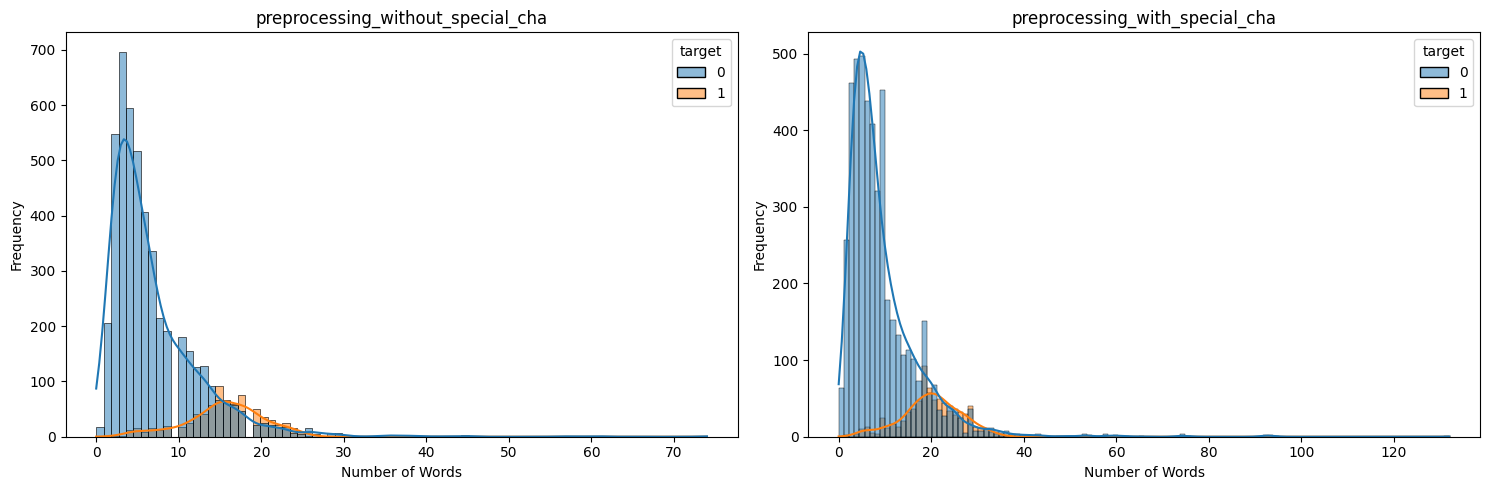

In all cases, it seems that spams contain longer messages than hams. It seems more clear when removing special characters.


In [ ]:
# Word Frequency Analysis

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, (df_name, df) in enumerate(df_preprocessed_dict.items()):
    # Calculate word count for each text
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    ax = axes[i]
    sns.histplot(data=df, x="word_count", hue="target", kde=True, ax=ax) # hue is color differenciation ; kde = kernel density estimation (estimation of the underlying probability density function of the data)
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency")
    ax.set_title(df_name)

plt.tight_layout()
plt.show()

print("In all cases, it seems that spams contain longer messages than hams. It seems more clear when removing special characters.")

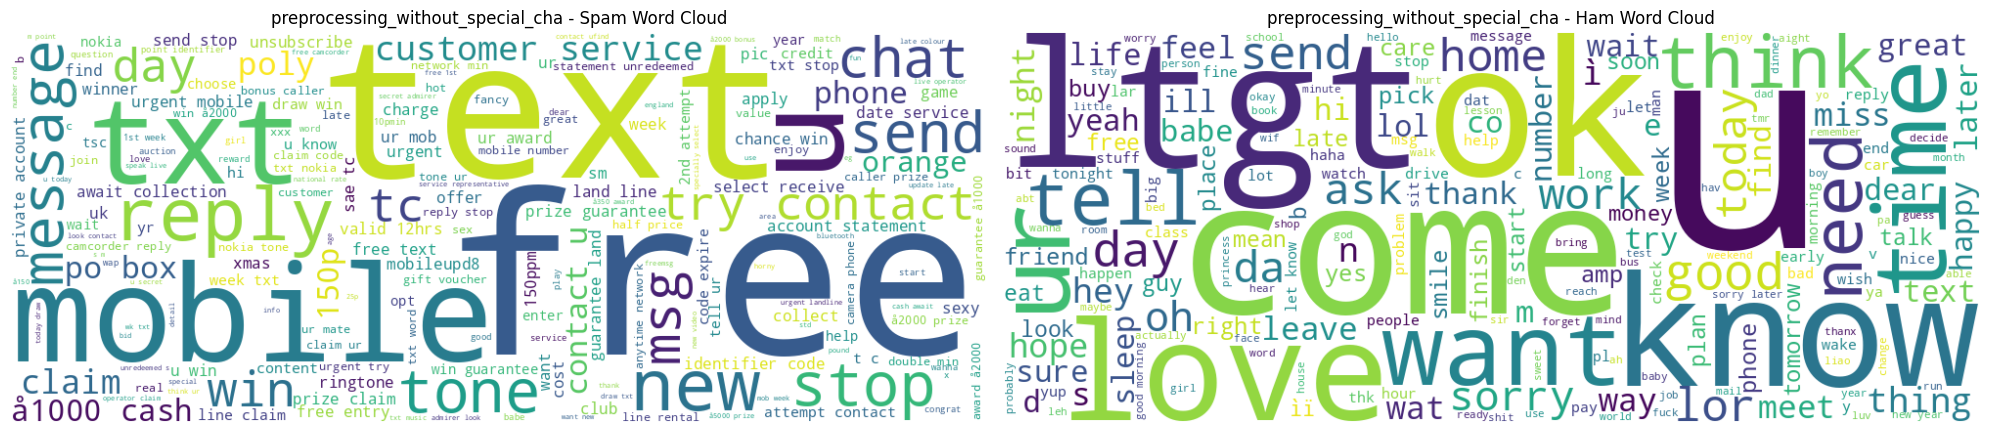

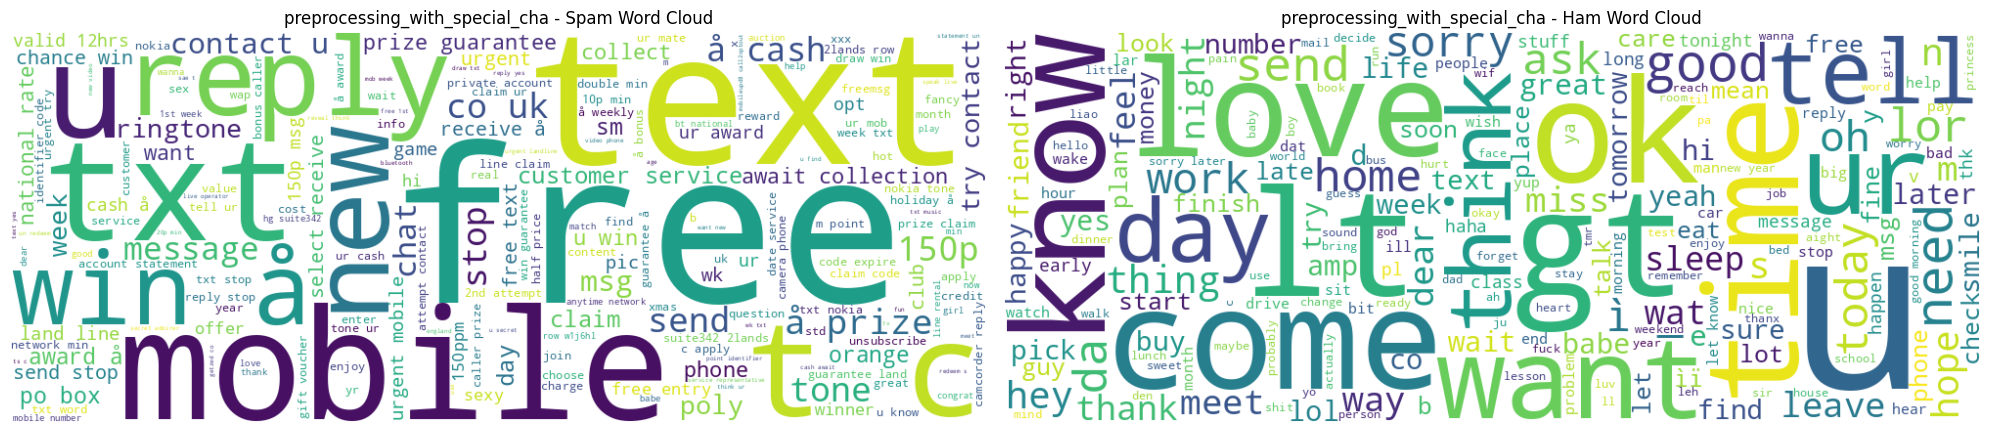

We see here that spams contains a lot the words: free, text, mobile, reply, cash, sexy etc. which are words related to advertisment.
In the opposite, the hams contain random words about everything.


In [ ]:
# Word clouds

for df_name, df in df_preprocessed_dict.items():
    # Separate by spam and ham
    spam_data = df[df['target'] == 1]['cleaned_text']
    ham_data = df[df['target'] == 0]['cleaned_text']

    # Word Cloud for spam data / ham data
    spam_text = ' '.join(spam_data)
    spam_wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(spam_text)
    ham_text = ' '.join(ham_data)
    ham_wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(ham_text)

    # Plot Word Clouds
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(spam_wordcloud, interpolation='bilinear')
    axes[0].set_title(f"{df_name} - Spam Word Cloud")
    axes[0].axis('off')
    axes[1].imshow(ham_wordcloud, interpolation='bilinear')
    axes[1].set_title(f"{df_name} - Ham Word Cloud")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

print("We see here that spams contains a lot the words: free, text, mobile, reply, cash, sexy etc. which are words related to advertisment.")
print("In the opposite, the hams contain random words about everything.")

#MODELS

###Word Embedding

In [ ]:
embedding_dim=16

# Create lists to store useful analysis data
loss_values = []
val_loss_values = []
accuracy_values = []
val_accuracy_values = []
confusion_matrix_lists = []


for df_name, df in df_preprocessed_dict.items():
    text_pad = tf.keras.preprocessing.sequence.pad_sequences(df["encoded_text"], padding="post")
    # Train Test Split
    xtrain, xval, ytrain, yval = train_test_split(text_pad,df.target, test_size=0.3, stratify=df["target"])
    train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
    val = tf.data.Dataset.from_tensor_slices((xval, yval))
    train_batch = train.shuffle(len(train)).batch(64)
    val_batch = val.shuffle(len(val)).batch(64)
    vocab_size = tokenizer.num_words
    embedding_dim=16
    model= tf.keras.Sequential([
                      # Couche d'Input Word Embedding
                      tf.keras.layers.Embedding(vocab_size+1,embedding_dim, input_shape=[text_pad.shape[1],],name="embedding"),
                      # Gobal average pooling
                      tf.keras.layers.GlobalAveragePooling1D(),

                      # Couche Dense classique
                      tf.keras.layers.Dense(16, activation='relu'),

                      # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                      tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    history = model.fit(train_batch, epochs=30, validation_data=val_batch)
    # Save loss and accuracy into lists
    loss_values.append(history.history["loss"])
    val_loss_values.append(history.history["val_loss"])
    accuracy_values.append(history.history["accuracy"])
    val_accuracy_values.append(history.history["val_accuracy"])

    # Get the model's predictions
    ypreds = np.round(model.predict(xval))
    # Calculate evaluation metrics
    f1_metric = f1_score(yval, ypreds)
    precision = precision_score(yval, ypreds)
    recall = recall_score(yval, ypreds)
    print(df_name)
    print("F1 Score:", f1_metric)
    print("Precision Score:", precision)
    print("Recall:", recall)
    confusion_matrix_values = confusion_matrix(yval, ypreds)
    confusion_matrix_lists.append(confusion_matrix_values)

Epoch 1/30
61/61 [==============================] - 3s 13ms/step - loss: 0.6533 - accuracy: 0.8295 - val_loss: 0.5916 - val_accuracy: 0.8660
Epoch 2/30
61/61 [==============================] - 1s 8ms/step - loss: 0.4866 - accuracy: 0.8659 - val_loss: 0.4000 - val_accuracy: 0.8660
Epoch 3/30
61/61 [==============================] - 1s 10ms/step - loss: 0.3685 - accuracy: 0.8659 - val_loss: 0.3553 - val_accuracy: 0.8660
Epoch 4/30
61/61 [==============================] - 1s 10ms/step - loss: 0.3454 - accuracy: 0.8659 - val_loss: 0.3446 - val_accuracy: 0.8660
Epoch 5/30
61/61 [==============================] - 0s 6ms/step - loss: 0.3332 - accuracy: 0.8659 - val_loss: 0.3332 - val_accuracy: 0.8660
Epoch 6/30
61/61 [==============================] - 0s 6ms/step - loss: 0.3176 - accuracy: 0.8659 - val_loss: 0.3167 - val_accuracy: 0.8660
Epoch 7/30
61/61 [==============================] - 0s 7ms/step - loss: 0.2942 - accuracy: 0.8659 - val_loss: 0.2921 - val_accuracy: 0.8660
Epoch 8/30
61/61 

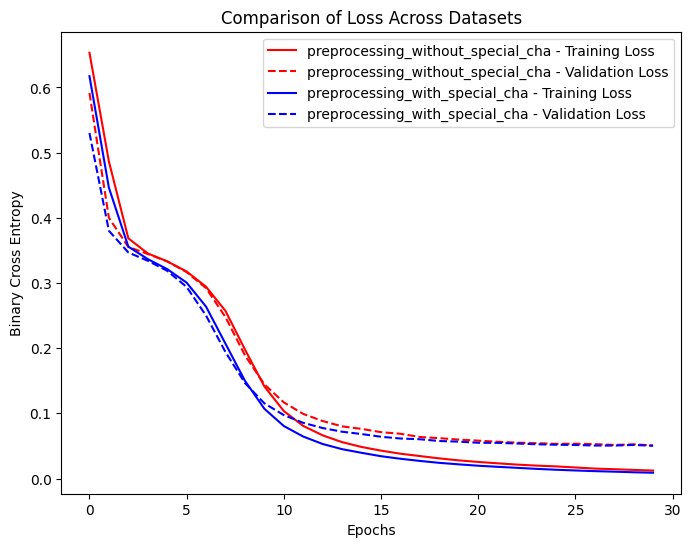

In [ ]:
# Visualization of the training process on the loss function

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]
for i, (loss, val_loss, df_name) in enumerate(zip(loss_values, val_loss_values, df_preprocessed_dict.keys())):
    color = colors[i % len(colors)] # i divided by number of colors, to know where we are
    plt.plot(loss, color=color, linestyle='-', label=f"{df_name} - Training Loss")
    plt.plot(val_loss, color=color, linestyle='--', label=f"{df_name} - Validation Loss")
plt.ylabel("Binary Cross Entropy")
plt.xlabel("Epochs")
plt.title("Comparison of Loss Across Datasets")
plt.legend()
plt.show()


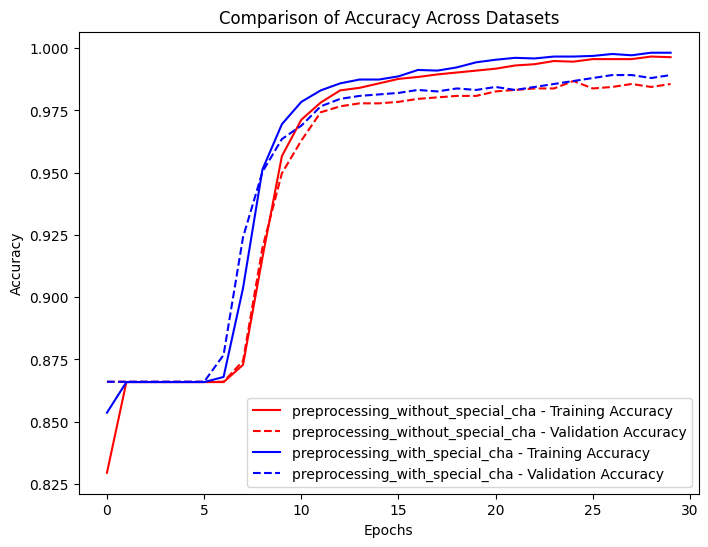

In [ ]:
# Visualization of accuracy training

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]
for i, (accuracy, val_accuracy, df_name) in enumerate(zip(accuracy_values, val_accuracy_values, df_preprocessed_dict.keys())):
    color = colors[i % len(colors)]
    plt.plot(accuracy, color=color, linestyle='-', label=f"{df_name} - Training Accuracy")
    plt.plot(val_accuracy, color=color, linestyle='--', label=f"{df_name} - Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Comparison of Accuracy Across Datasets")
plt.legend()
plt.show()

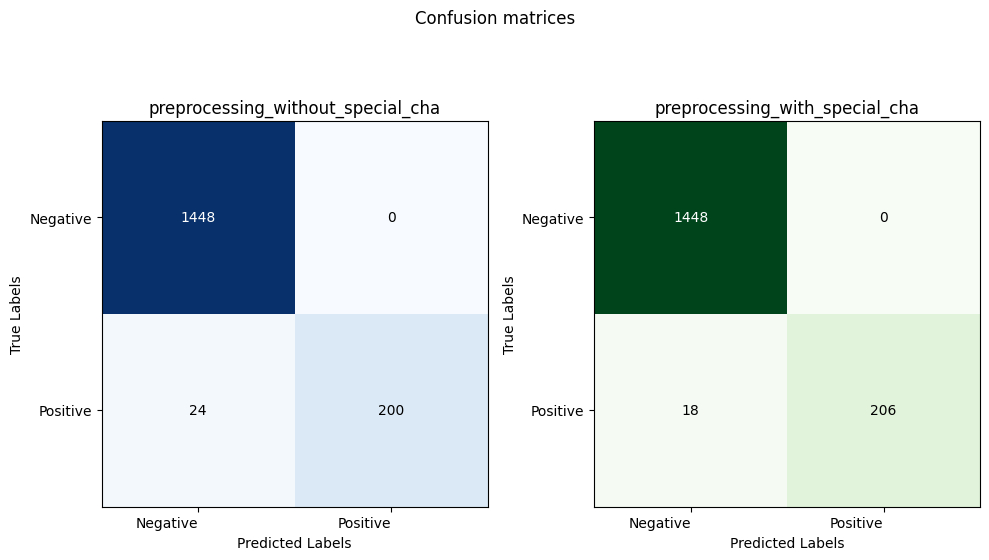

Here we also confirmed that the best preprocessing was the green one. The green confusion matrix shows better results with more true positive


In [ ]:
# Confusion matrix

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
colors = [ "Blues", "Greens"]

for i, (confusion_matrix, df_name) in enumerate(zip(confusion_matrix_lists, df_preprocessed_dict.keys())):
    # Plot confusion matrix
    ax = axs[i]
    ax.imshow(confusion_matrix, cmap=colors[i % len(colors)])
    ax.set_title(f'{df_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # Set tick labels
    classes = ['Negative', 'Positive']
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Rotate tick labels and set alignment
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            text_color = "white" if (i == 0 and j == 0) else "black"  # Set text color to white for true negatives (too dark background)
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color=text_color)
plt.suptitle("Confusion matrices")
plt.tight_layout()
plt.show()

print("Here we also confirmed that the best preprocessing was the green one. The green confusion matrix shows better results with more true positive")